# Dense ODE-Net for solving Schrödinger's Equation

## Overview
Schrödinger's equation describes the evolution of closed quantum system. Recent researches reveal the linkage between modern neural network structure such as residual connection and differential equations: [Bridging Deep Architectures and Numerical Differential Equations](https://arxiv.org/pdf/1710.10121.pdf); [Neural Ordinary Differential Equations](https://arxiv.org/pdf/1806.07366.pdf). The key idea is that connections between layers of neural network are related to the discrete structure of a differential equation. E.g. the residual connection is equal to the identity mapping. As a further work of ResNet, DenseNet introduces dense connections enabling more complex topological structure. Inspired by these researches, We Introduce Dense Connections to learn the discrete structure of a differential equation such as Schrödinger's Equation in this demo.

## Problem Description
This case solves the forward problem of Schrödinger's Equation and realizes long-term prediction of systems with random Hamiltonian. We use a network we call "Dense ODE-Net". Note that every random Hamiltonian in this demo is hermitian, further non-hermitian Hamiltonian such as PT-Symmetric Hamiltonian is not taken into consideration yet.

## Schrodinger equation
$$
i\hbar\dfrac{\partial|\Psi>}{\partial t} = H|\Psi>
$$

$$
H=H^\dagger
$$

## Dense ODE-Net: Model Structure
The cell of Dense ODE-Net contains $depth$ layers, all layers share the same weight $H$, which is determined by the hamiltonian. The trainable parameters are the weights of dense connections between layers. $W_{i,j}$ means the weight of the connection from layer i to layer j, note that $W_{0,depth}$ is frozen to 1 to ensure an identity mapping from input to output.
![Cell](images/Dense_Cell.png)

Many famous discretization scheme can be obtained from the network by setting appropriate dense connection weights.
Such as: Forward Euler Method

![Forward Euler](images/Forward_Euler.png)

4th Runge-Kutta also can be derived from dense ode-net

![Fourth_Runge_Kutta Euler](images/Fourth_Runge_Kutta.png)

## Technical Roadmap
We solve the problem described above as follows:
1. Model Construction.
2. Training with increasing time steps.
3. Test with random Hamiltonian & Visualization

In [1]:
import mindspore as ms
import numpy as np
import os
from mindspore import nn
from mindspore.amp import all_finite
from src.dense_ode_net import DenseODENet, DenseODENetWithLoss
from src.data_generate import Generator
from utils import generate_train_data, init_env, makedir, get_config, evaluate, test

## Training Environment Settings

In [2]:
ms.set_seed(1999)
np.random.seed(1999)
my_config = get_config('./config.yaml')
makedir(my_config)
my_config['device_target'] = 'CPU'
my_config['mode'] = 'pynative'
my_config['device_id'] = 0
ms.set_context(mode=ms.PYNATIVE_MODE, device_target=my_config['device_target'], device_id=my_config['device_id'])
print('----------------------------- Env settings -----------------------------')
print('running on {}, device id: {}, context mode: {}'.format(my_config['device_target'], my_config['device_id'],
                                                              my_config['mode']))

----------------------------- Env settings -----------------------------
running on CPU, device id: 0, context mode: pynative


## Model Construction
Dense ODE-Net is defined in class DenseODENet. You need to specify the depth of network, dimensions of hamiltonian, initial range of dense connection weights, maximum time-step of network.

In [3]:
def init_model(config):
    model = DenseODENet(depth=config['depth'], h_dim=config['h_dim'], init_range=config['w_init_range'],
                        max_dt=config['max_dt'])
    return model

## Define single training with specific time steps.

In [4]:
def single_train(config, time_step: int, net_with_loss: DenseODENetWithLoss, data_generator):
    lr = config['lr'] * np.power(config['lr_reduce_gamma'], (time_step - 1) // config['lr_reduce_interval'])
    my_optimizer = nn.Adam(params=net_with_loss.ode_net.trainable_params(), learning_rate=lr)

    def forward_fn(h, trajectory, t_points):
        loss = net_with_loss.get_loss(H=h, batch_trajectories=trajectory, t_points=t_points)
        return loss
    value_and_grad = ms.ops.value_and_grad(forward_fn, None, weights=my_optimizer.parameters)

    def train_process(h, trajectory, t_points):
        loss, grads = value_and_grad(h, trajectory, t_points)
        if all_finite(grads):
            my_optimizer(grads)
        return loss

    train_dataset = generate_train_data(config=config, data_generator=data_generator, time_step=time_step)
    for epoch_idx in range(1, config['epochs'] + 1):
        net_with_loss.ode_net.set_train(mode=True)
        avg_loss = 0
        for H, trajectories, time_points in train_dataset.fetch():
            train_loss = train_process(H, trajectories, time_points)
            avg_loss += train_loss.asnumpy()
        print('time_step: {} -- epoch: {} -- lr: {} -- loss: {}'.format(time_step, epoch_idx, lr, avg_loss))

        # generate new data
        if epoch_idx % config['generate_data_interval'] == 0:
            train_dataset = generate_train_data(config=config, data_generator=data_generator, time_step=time_step)
    # save
    save_path = os.path.join(config['save_directory'], 'dense_ode_net_step{}.ckpt'.format(time_step))
    ms.save_checkpoint(net_with_loss.ode_net, save_path)
    # evaluate
    evaluate(config=config, model=net_with_loss.ode_net, data_generator=data_generator)
    print('-- Current Dense Weight')
    print(net_with_loss.ode_net.dense_w())
    return

## Training

In [5]:
def train(config):
    data_generator = Generator(dim=config['h_dim'])
    dense_ode_net = init_model(config)
    net_with_loss = DenseODENetWithLoss(ode_net=dense_ode_net)
    # first evaluate
    evaluate(config=config, model=net_with_loss.ode_net, data_generator=data_generator)
    print('-- Current Dense Weight')
    print(net_with_loss.ode_net.dense_w())

    for time_step in range(1, config['time_step_num'] + 1):
        single_train(config=config, time_step=time_step, net_with_loss=net_with_loss, data_generator=data_generator)
    return

In [6]:
train(my_config)

H 1 test forward ...
H 2 test forward ...
H 3 test forward ...
H 4 test forward ...
H 5 test forward ...
H 6 test forward ...
H 7 test forward ...
H 8 test forward ...
H 9 test forward ...
H 10 test forward ...
=================================== evaluate ===================================
-- Max evaluate relative L2 error: 1.9590126276016235
-- Current Dense Weight
[[0.         0.9459363  0.9811951  0.9636938  1.        ]
 [0.         0.9143088  0.93390936 0.9901344  0.9833571 ]
 [0.         0.         0.9606229  0.9006332  0.9131826 ]
 [0.         0.         0.         0.9657586  0.98012316]
 [0.         0.         0.         0.         0.9815558 ]]
time_step: 1 -- epoch: 1 -- lr: 0.005 -- loss: 9.402620480614132e-05
time_step: 1 -- epoch: 2 -- lr: 0.005 -- loss: 7.33129054424353e-05
time_step: 1 -- epoch: 3 -- lr: 0.005 -- loss: 5.6141401728382334e-05
time_step: 1 -- epoch: 4 -- lr: 0.005 -- loss: 4.281160431673925e-05
time_step: 1 -- epoch: 5 -- lr: 0.005 -- loss: 3.25738128594821

## Test with random Hamiltonian

=============== Net saved at step 20 is loaded. ===============
H 1 test forward ...
H 2 test forward ...
H 3 test forward ...
H 4 test forward ...
H 5 test forward ...
H 6 test forward ...
H 7 test forward ...
H 8 test forward ...
H 9 test forward ...
H 10 test forward ...
H 11 test forward ...
H 12 test forward ...
H 13 test forward ...
H 14 test forward ...
H 15 test forward ...
H 16 test forward ...
H 17 test forward ...
H 18 test forward ...
H 19 test forward ...
H 20 test forward ...
H 21 test forward ...
H 22 test forward ...
H 23 test forward ...
H 24 test forward ...
H 25 test forward ...
H 26 test forward ...
H 27 test forward ...
H 28 test forward ...
H 29 test forward ...
H 30 test forward ...
H 31 test forward ...
H 32 test forward ...
H 33 test forward ...
H 34 test forward ...
H 35 test forward ...
H 36 test forward ...
H 37 test forward ...
H 38 test forward ...
H 39 test forward ...
H 40 test forward ...
H 41 test forward ...
H 42 test forward ...
H 43 test forward ...

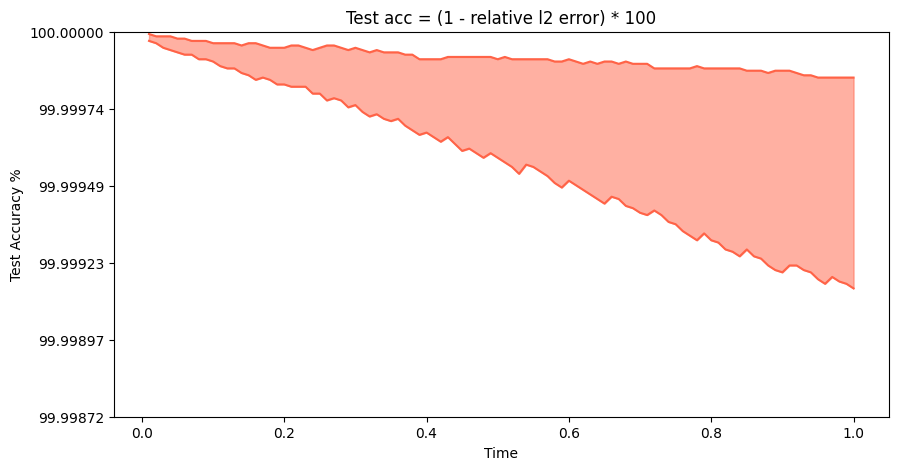

In [7]:
test(my_config, show_results=True)